# Taylor's Power Law

In [2]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import PlackettBurman, DOE, FullFactorial
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import AbstractSimulator, Sim1, Circuit, MLR, Sparse

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir

conf = Config()

In [4]:
noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=.5)),
    dict(kwarg_err=dict(loc=0, scale=1)),
    dict(kwarg_err=dict(loc=0, scale=2)),
]

noise_names = [
    r"$\sigma=0.5$",
    r"$\sigma=1$",
    r"$\sigma=2$"
]

simulators = dict(
    sim1=list(map(lambda x: x(), [Sim1] * len(noise_conf))), 
    circuit=list(map(lambda x: x(), [Circuit] * len(noise_conf))), 
    sparse=list(map(lambda x: x(), [Sparse] * len(noise_conf)))
)

exmatrix = FullFactorial().get_exmatrix(n_factor=9)()
n_rep = 10

np.random.seed(0)
random_state = np.random.randint(0, 2**32, len(simulators) * len(noise_conf))

In [487]:
from scipy.stats import pearsonr

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

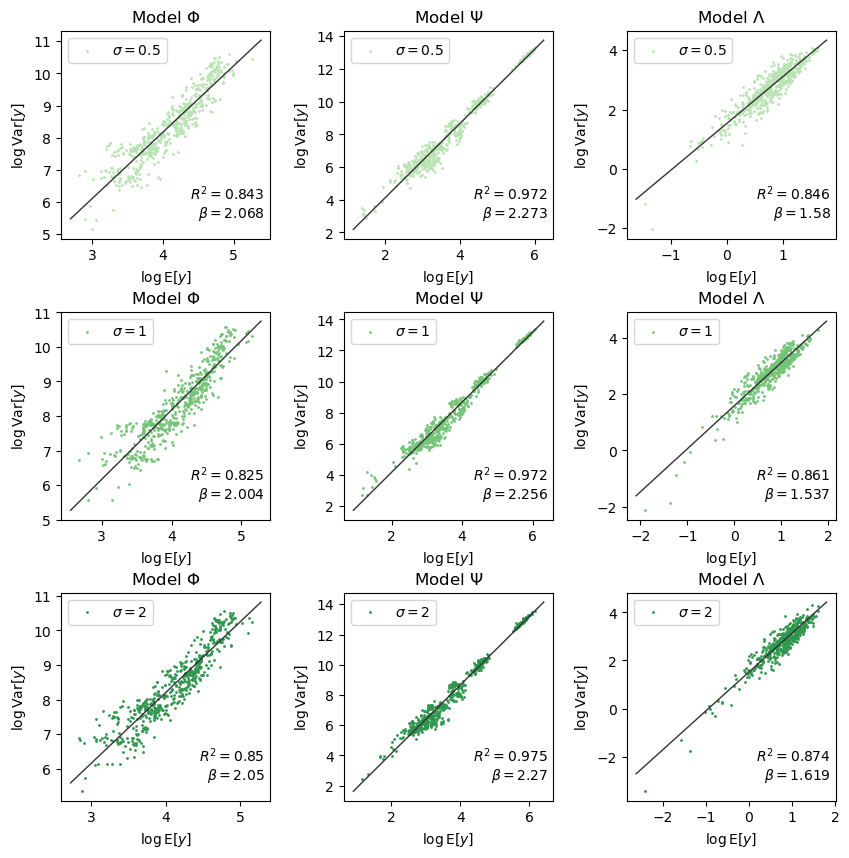

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(hspace=.35, wspace=.35)

for i, model_list in tqdm(enumerate(simulators.values()), total=len(simulators)):
    for ii, model in tqdm(enumerate(model_list), total=len(model_list)):
        np.random.seed(random_state[len(noise_conf) * i + ii])
        seeds = np.random.randint(0, 2**32, len(exmatrix) * n_rep)
        
        expressions = []
        output = []
        for iii, s in enumerate(seeds):
            model.run(exmatrix.iloc[iii // n_rep, :], random_state=s)
            expressions += [list(model.x.values())]
            output += [[model.y]]
        
        ym = np.array(output).reshape(n_rep, -1).T.mean(axis=1)
        yv = np.array(output).reshape(n_rep, -1).T.var(axis=1)

        lrm = LinearRegression()
        lrm.fit(np.log(ym).reshape(-1, 1), np.log(yv))

        ax[ii, i].scatter(
            np.log(ym), np.log(yv), s=1, color=plt.cm.Greens((ii + 1.5)/ (len(noise_conf) + 2)), 
            # label=r"$R^2=$" + f"{lrm.score(np.log(ym).reshape(-1, 1), np.log(yv)).round(3)}"
            label=noise_names[ii]
        )

        xlim, ylim = ax[ii, i].get_xlim(), ax[ii, i].get_ylim()

        ax[ii, i].plot(
            xlim, lrm.coef_ * np.array(xlim) + lrm.intercept_, 
            lw=1, c=".2",
            # label = "$y=$" + f"{lrm.intercept_.round(3)}" + "$+$" + f"{lrm.coef_.round(3).item()}" + "$x$"
        )

        ax[ii, i].set(
            title=model.name,
            xlabel="$\log$" + "E" + "$[y]$", ylabel="$\log$" + "Var" + "$[y]$"
        )
        ax[ii, i].legend(fontsize="medium")
        
        xlim, ylim = ax[ii, i].get_xlim(), ax[ii, i].get_ylim()
        ax[ii, i].text(
            max(xlim), min(ylim), 
            r"$R^2=$" + f"{lrm.score(np.log(ym).reshape(-1, 1), np.log(yv)).round(3)}"  + "  \n" + \
            r"$\beta=$" + f"{lrm.coef_.round(3).item()}  \n", 
            # "$\log$" + "Var" + "$[y]=$" + f"{lrm.intercept_.round(3)}" + \
            # "$+$" + f"{lrm.coef_.round(3).item()}" + "$\log$" + "E" + "$[y]$",
            ha="right", va="bottom"
        )
        ax[ii, i].set_xlim(*xlim)
        ax[ii, i].set_ylim(*ylim)

if conf.savefig:
    fig.savefig(f"{conf.out}/taylor", **kwarg_savefig)

In [496]:
r, p = pearsonr(ym, yv)
print(r)
print(r)

0.8692023871636404
0.8692023871636404


In [141]:
from doe_modules.simulation import MLR
from doe_modules.design import CLOO

In [7]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from doe_modules.simulation import AbstractSimulator
from doe_modules.design import DOE
from doe_modules.preferences import textcolor
# from doe_modules.preferences.cmap import test4

In [8]:
test9 = [plt.cm.nipy_spectral((i + 2)/11) for i in range(9)]

In [209]:
class Test9(AbstractSimulator):
    def __init__(
        self, 
        edge_assignsment: list,
        random_state: int = 0,
        model_id: int = "",
        kwarg_v: dict = dict(mean=1, sigma=.8),
        kwarg_a: dict = dict(mean=2, sigma=.3),
        kwarg_b: dict = dict(mean=1, sigma=.5)
    ):
        super().__init__(
            n_factor=9, random_state=random_state, cmap=test9, 
            name="ESM9" if model_id == "" else f"ESM9-#{model_id}"
        )
        seeds = np.random.randint(0, 2**32, 3)
        np.random.seed(seeds[0])
        self.v = {
            i+1: vi for i, vi in enumerate(
                np.random.lognormal(**kwarg_v, size=self.n_factor)
            )
        }
        np.random.seed(seeds[1])
        self.a = {
            i: sign * a for i, a, sign in zip(
                np.arange(1, self.n_factor + 1).astype(int),
                np.random.lognormal(**kwarg_a, size=self.n_factor),
                edge_assignsment[:self.n_factor]
            )
        }
        np.random.seed(seeds[2])
        self.b = {
            i: sign * b for i, b, sign in zip(
                [
                    12, 13, 14, 15, 16, 17, 18, 19, 
                    23, 24, 25, 26, 27, 28, 29,
                    34, 35, 36, 37, 38, 39,
                    45, 46, 47, 48, 49,
                    56, 57, 58, 59,
                    67, 68, 69,
                    78, 79, 
                    89
                ],
                np.random.lognormal(**kwarg_b, size=36),
                edge_assignsment[self.n_factor:]
            )
        }

    def run(
        self, 
        design_array, 
        random_state: int = 0,
        kwarg_err: dict = dict(loc=0, scale=1),
    ):
        super().run(design_array=design_array, random_state=random_state)
        e = np.random.normal(**kwarg_err, size=10)
        f = lambda x: max(0, x)
        c = self.c
        
        upstreams = {}
        xs = {}
        idx_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        
        for i in idx_list:
            upstream_list = [ii for ii in idx_list if ii < i]
            upstream = 0 if len(upstream_list) == 0 else np.sum([self.b[10 * ii + i] * xs[ii] for ii in xs])
            xs = {**xs, i: f(c[i] * (self.v[i] + e[i] + upstream))}
            # print(xs)
        self.c = c
        self.x = xs
        self.y = f(sum([self.a[i + 1] * self.x[i + 1] for i in range(self.n_factor)]) + e[0])
        return self.y
    

    def plot(
        self,
        ax: plt.Axes
    ):
        def curve(p1, p2, h, cap: bool):
            A, B = p1
            C, D = p2
            kb = (B - h)
            kd = (D - h)
            fa = (kb - kd) / kb
            fb = (A * kd - C * kb) / kb
            fc = (kb * C ** 2 - kd * A ** 2) / kb
            rt = np.sqrt(fb ** 2 - fa * fc)
            p = (-fb - rt) / fa if cap else (-fb + rt) / fa
            a = kb / (A - p) ** 2
            return np.vectorize(lambda x: a * (x - p) ** 2 + h)

        def get_top(p1, p2, h, cap: bool):
            A, B = p1
            C, D = p2
            kb = (B - h)
            kd = (D - h)
            fa = (kb - kd) / kb
            fb = (A * kd - C * kb) / kb
            fc = (kb * C ** 2 - kd * A ** 2) / kb
            rt = np.sqrt(fb ** 2 - fa * fc)
            p = (-fb - rt) / fa if cap else (-fb + rt) / fa
            return (p, h)

        dat = pd.DataFrame(dict(x=np.arange(2, 11), y=np.arange(9, 0, -1)))

        sns.scatterplot(
            data=dat,
            x="x",
            y="y", 
            c=test9, s=300, lw=0
        )

        fmt_curve = lambda p1, p2, h: (np.linspace(p1[0], p2[0]), [curve(p1, p2, h, True)(v) for v in np.linspace(p1[0], p2[0])])


        box_top = -2
        box_bottom = -3

        ax.fill_between([1.5, 10.5], [box_bottom] * 2, [box_top] * 2, color=".7", alpha=.2)
        ax.text(6, (box_top + box_bottom) / 2, "output value", ha="center", va="center")

        for i in range(9):
            x, y = dat.x[i], dat.y[i]
            alpha = np.linspace(0.5, 1, 9)[i]
            ax.text(x, y, "$x_" + f"{(i + 1)}" + "$", va="center", ha="center", c=textcolor(test9[i]))
            
            if self.a[i + 1] != 0:
                ax.vlines(x, box_top, y, color=test9[i], zorder=-100, alpha=alpha)
                ax.scatter(
                    x, box_top + .25 if self.a[i + 1] > 0 else box_top, 
                    color=test9[i], marker="v" if self.a[i + 1] > 0 else "$-$"
                )
                ax.text(x, box_top + 1, "$a_" + f"{(i + 1)}" + "$", va="center", ha="left")

            for ii, j in enumerate(np.arange(i + 1, 9)):
                if self.b[10 * (i + 1) + j + 1] != 0:
                    x2, y2 = dat.x[j], dat.y[j]
                    if ii == 0:
                        ax.plot([x, x2], [y, y2], c=test9[i], zorder=-100, alpha=alpha)
                        ax.scatter(
                            x2 - .39 if self.b[10 * (i + 1) + j + 1] > 0 else x2 - .33, 
                            y2 + .5 if self.b[10 * (i + 1) + j + 1] > 0 else y2 + .35, 
                            color=test9[i], marker="^" if self.b[10 * (i + 1) + j + 1] > 0 else "$|$",
                            alpha=alpha
                        )
                        ax.text((x + x2) / 2, y2, "$b_{" + f"{(i + 1)}{(j + 1)}" + "}$", va="top", ha="center")
                    else:
                        h = y + ii + 0.2 * i + 1
                        ax.plot(*fmt_curve((x,y), (x2,y2), h), zorder=-100, c=test9[i], alpha=alpha)
                        ax.scatter(
                            x2 - .15 if self.b[10 * (i + 1) + j + 1] > 0 else x2 - .1, 
                            y2 + .86 if self.b[10 * (i + 1) + j + 1] > 0 else y2 + .7, 
                            color=test9[i], marker="<" if self.b[10 * (i + 1) + j + 1] > 0 else "$-$",
                            alpha=alpha
                        )
                        ax.text(*get_top((x,y), (x2,y2), h, True), "$b_{" + f"{(i + 1)}{(j + 1)}" + "}$", va="bottom", ha="center")

        ax.set_xlim(1.5, 10.5)
        ax.set_ylim(-3.0, 18)
        ax.axis("off");
        
#  
#         return None


    def simulate(
        self,
        design: DOE = None,
        n_rep: int = 1,
        random_state: int = 0,
        plot: bool = False,
        ax: np.ndarray = None,
        titles: List[str] = None,
        model_kwargs: dict = {},
        **kwargs
    ):
        super().simulate(
            design=design, n_rep=n_rep,
            random_state=random_state,
            plot=plot, ax=ax, 
            titles=titles,
            model_kwargs=model_kwargs,
            **kwargs
        )


    def scatterview(
        self,
        ax: plt.Axes
    ):
        super().scatterview(ax=ax)

In [10]:
from doe_modules.preferences import harmonic_mean

In [11]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

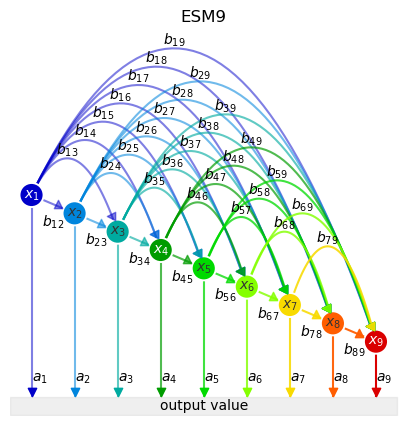

In [399]:
fig, ax = plt.subplots(figsize=(5, 5))

esm9 = Test9(
    edge_assignsment=np.ones(45),
)

esm9.plot(ax=ax)

ax.set_title("ESM9")

if conf.savefig:
    fig.savefig(f"{outputdir}/esm9", **kwarg_savefig)

In [254]:
edges = np.random.randint(-1, 2, (10000, 45))

conditions = dict(
    ff=[Test9(v, model_id=i) for i, v in enumerate(edges)],
    pb=[Test9(v, model_id=i) for i, v in enumerate(edges)],
    cloo=[Test9(v, model_id=i) for i, v in enumerate(edges)],
)

designs = dict(
    ff=FullFactorial,
    pb=PlackettBurman,
    cloo=CLOO,
)

In [255]:
for k, models in tqdm(conditions.items(), total=3):
    [
        m.simulate(
            design=designs[k], n_rep=3
        ) for (i, m) in tqdm(enumerate(models), total=len(edges))
    ]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [305]:
def n_pathways(arr) -> int:
    return np.abs(arr)[:9].sum()

def n_edges(arr) -> int:
    return np.abs(arr)[9:].sum()

def pathway_coverage(arr) -> float:
    full = arr[:9].size
    return n_pathways(arr) / full

def sparse_pathway_coverage(arr):
    return (arr[:9] == 0).sum() / arr[:9].size

def edge_coverage(arr) -> float:
    full = arr[9:].size
    return n_edges(arr) / full


def n_eff(arr):
    return np.array([
        (arr[9] != 0) & (
            (arr[1] != 0) or \
            (arr[(17, 2),] != 0).all() or \
            (arr[(17, 24, 3),] != 0).all() or (arr[(17, 24, 30, 4),] != 0).all() or (arr[(17, 24, 30, 35, 5),] != 0).all() or \
            (arr[(17, 24, 30, 35, 39, 6),] != 0).all() or \
            (arr[(17, 24, 30, 35, 39, 42, 7),] != 0).all() or (arr[(17, 24, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(17, 24, 30, 35, 39, 43, 8),] != 0).all() or (arr[(17, 24, 30, 35, 40, 7),] != 0).all() or \
            (arr[(17, 24, 30, 35, 40, 44, 8),] != 0).all() or (arr[(17, 24, 30, 35, 41, 8),] != 0).all() or \
            (arr[(17, 24, 30, 36, 6),] != 0).all() or (arr[(17, 24, 30, 36, 42, 7),] != 0).all() or (arr[(17, 24, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(17, 24, 30, 36, 43, 8),] != 0).all() or \
            (arr[(17, 24, 30, 37, 7),] != 0).all() or (arr[(17, 24, 30, 37, 44, 8),] != 0).all() or \
            (arr[(17, 24, 30, 38, 8),] != 0).all() or \
            (arr[(17, 24, 31, 5),] != 0).all() or \
            (arr[(17, 24, 31, 39, 6),] != 0).all() or (arr[(17, 24, 31, 39, 42, 7),] != 0).all() or (arr[(17, 24, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(17, 24, 31, 39, 43, 8),] != 0).all() or (arr[(17, 24, 31, 40, 7),] != 0).all() or (arr[(17, 24, 31, 40, 44, 8),] != 0).all() or \
            (arr[(17, 24, 31, 41, 8),] != 0).all() or \
            (arr[(17, 24, 32, 6),] != 0).all() or \
            (arr[(17, 24, 32, 42, 7),] != 0).all() or (arr[(17, 24, 32, 42, 44, 8),] != 0).all() or (arr[(17, 24, 32, 43, 8),] != 0).all() or \
            (arr[(17, 24, 33, 7),] != 0).all() or \
            (arr[(17, 24, 33, 44, 8),] != 0).all() or \
            (arr[(17, 24, 34, 8),] != 0).all() or \
            (arr[(17, 25, 4),] != 0).all() or (arr[(17, 25, 35, 5),] != 0).all() or (arr[(17, 25, 35, 39, 6),] != 0).all() or (arr[(17, 25, 35, 39, 42, 7),] != 0).all() or \
            (arr[(17, 25, 35, 39, 42, 44, 8),] != 0).all() or (arr[(17, 25, 35, 39, 43, 8),] != 0).all() or (arr[(17, 25, 35, 40, 7),] != 0).all() or \
            (arr[(17, 25, 35, 40, 44, 8),] != 0).all() or (arr[(17, 25, 35, 41, 8),] != 0).all() or \
            (arr[(17, 25, 36, 6),] != 0).all() or (arr[(17, 25, 36, 42, 7),] != 0).all() or (arr[(17, 25, 36, 42, 44, 8),] != 0).all() or \
            (arr[(17, 25, 36, 43, 8),] != 0).all() or \
            (arr[(17, 25, 37, 7),] != 0).all() or (arr[(17, 25, 37, 44, 8),] != 0).all() or \
            (arr[(17, 25, 38, 8),] != 0).all() or \
            (arr[(17, 26, 5),] != 0).all() or (arr[(17, 26, 39, 6),] != 0).all() or (arr[(17, 26, 39, 42, 7),] != 0).all() or \
            (arr[(17, 26, 39, 42, 44, 8),] != 0).all() or \
            (arr[(17, 26, 39, 43, 8),] != 0).all() or (arr[(17, 26, 40, 7),] != 0).all() or (arr[(17, 26, 40, 44, 8),] != 0).all() or (arr[(17, 26, 41, 8),] != 0).all() or \
            (arr[(17, 27, 6),] != 0).all() or (arr[(17, 27, 42, 7),] != 0).all() or (arr[(17, 27, 42, 44, 8),] != 0).all() or (arr[(17, 27, 43, 8),] != 0).all() or \
            (arr[(17, 28, 7),] != 0).all() or (arr[(17, 28, 44, 8),] != 0).all() or \
            (arr[(17, 29, 8),] != 0).all() or \
            (arr[(18, 3),] != 0).all() or (arr[(18, 30, 4),] != 0).all() or (arr[(18, 30, 35, 5),] != 0).all() or (arr[(18, 30, 35, 39, 6),] != 0).all() or \
            (arr[(18, 30, 35, 39, 42, 7),] != 0).all() or (arr[(18, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(18, 30, 35, 39, 43, 8),] != 0).all() or (arr[(18, 30, 35, 40, 7),] != 0).all() or \
            (arr[(18, 30, 35, 40, 44, 8),] != 0).all() or (arr[(18, 30, 35, 41, 8),] != 0).all() or \
            (arr[(18, 30, 36, 6),] != 0).all() or (arr[(18, 30, 36, 42, 7),] != 0).all() or (arr[(18, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(18, 30, 36, 43, 8),] != 0).all() or \
            (arr[(18, 30, 37, 7),] != 0).all() or (arr[(18, 30, 37, 44, 8),] != 0).all() or \
            (arr[(18, 30, 38, 8),] != 0).all() or \
            (arr[(18, 31, 5),] != 0).all() or \
            (arr[(18, 31, 39, 6),] != 0).all() or (arr[(18, 31, 39, 42, 7),] != 0).all() or (arr[(18, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(18, 31, 39, 43, 8),] != 0).all() or (arr[(18, 31, 40, 7),] != 0).all() or (arr[(18, 31, 40, 44, 8),] != 0).all() or \
            (arr[(18, 31, 41, 8),] != 0).all() or \
            (arr[(18, 32, 6),] != 0).all() or \
            (arr[(18, 32, 42, 7),] != 0).all() or (arr[(18, 32, 42, 44, 8),] != 0).all() or (arr[(18, 32, 43, 8),] != 0).all() or \
            (arr[(18, 33, 7),] != 0).all() or \
            (arr[(18, 33, 44, 8),] != 0).all() or \
            (arr[(18, 34, 8),] != 0).all() or \
            (arr[(19, 4),] != 0).all() or (arr[(19, 35, 5),] != 0).all() or (arr[(19, 35, 39, 6),] != 0).all() or (arr[(19, 35, 39, 42, 7),] != 0).all() or \
            (arr[(19, 35, 39, 42, 44, 8),] != 0).all() or (arr[(19, 35, 39, 43, 8),] != 0).all() or (arr[(19, 35, 40, 7),] != 0).all() or \
            (arr[(19, 35, 40, 44, 8),] != 0).all() or (arr[(19, 35, 41, 8),] != 0).all() or \
            (arr[(19, 36, 6),] != 0).all() or (arr[(19, 36, 42, 7),] != 0).all() or (arr[(19, 36, 42, 44, 8),] != 0).all() or (arr[(19, 36, 43, 8),] != 0).all() or \
            (arr[(19, 37, 7),] != 0).all() or (arr[(19, 37, 44, 8),] != 0).all() or \
            (arr[(19, 38, 8),] != 0).all() or \
            (arr[(20, 5),] != 0).all() or (arr[(20, 39, 6),] != 0).all() or (arr[(20, 39, 42, 7),] != 0).all() or (arr[(20, 39, 42, 44, 8),] != 0).all() or \
            (arr[(20, 39, 43, 8),] != 0).all() or (arr[(20, 40, 7),] != 0).all() or (arr[(20, 40, 44, 8),] != 0).all() or (arr[(20, 41, 8),] != 0).all() or \
            (arr[(21, 6),] != 0).all() or (arr[(21, 42, 7),] != 0).all() or (arr[(21, 42, 44, 8),] != 0).all() or (arr[(21, 43, 8),] != 0).all() or \
            (arr[(22, 7),] != 0).all() or (arr[(44, 8),] != 0).all() or \
            (arr[(23, 8),] != 0).all()
        ),
        (arr[10] != 0) & (
            (arr[2] != 0) or \
            (arr[(24, 3),] != 0).all() or (arr[(24, 30, 4),] != 0).all() or (arr[(24, 30, 35, 5),] != 0).all() or (arr[(24, 30, 35, 39, 6),] != 0).all() or \
            (arr[(24, 30, 35, 39, 42, 7),] != 0).all() or (arr[(24, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 35, 39, 43, 8),] != 0).all() or (arr[(24, 30, 35, 40, 7),] != 0).all() or \
            (arr[(24, 30, 35, 40, 44, 8),] != 0).all() or (arr[(24, 30, 35, 41, 8),] != 0).all() or \
            (arr[(24, 30, 36, 6),] != 0).all() or (arr[(24, 30, 36, 42, 7),] != 0).all() or (arr[(24, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 36, 43, 8),] != 0).all() or \
            (arr[(24, 30, 37, 7),] != 0).all() or (arr[(24, 30, 37, 44, 8),] != 0).all() or \
            (arr[(24, 30, 38, 8),] != 0).all() or \
            (arr[(24, 31, 5),] != 0).all() or \
            (arr[(24, 31, 39, 6),] != 0).all() or (arr[(24, 31, 39, 42, 7),] != 0).all() or (arr[(24, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 31, 39, 43, 8),] != 0).all() or (arr[(24, 31, 40, 7),] != 0).all() or (arr[(24, 31, 40, 44, 8),] != 0).all() or \
            (arr[(24, 31, 41, 8),] != 0).all() or \
            (arr[(24, 32, 6),] != 0).all() or \
            (arr[(24, 32, 42, 7),] != 0).all() or (arr[(24, 32, 42, 44, 8),] != 0).all() or (arr[(24, 32, 43, 8),] != 0).all() or \
            (arr[(24, 33, 7),] != 0).all() or \
            (arr[(24, 33, 44, 8),] != 0).all() or \
            (arr[(24, 34, 8),] != 0).all() or \
            (arr[(25, 4),] != 0).all() or (arr[(25, 35, 5),] != 0).all() or (arr[(25, 35, 39, 6),] != 0).all() or (arr[(25, 35, 39, 42, 7),] != 0).all() or \
            (arr[(25, 35, 39, 42, 44, 8),] != 0).all() or (arr[(25, 35, 39, 43, 8),] != 0).all() or (arr[(25, 35, 40, 7),] != 0).all() or \
            (arr[(25, 35, 40, 44, 8),] != 0).all() or (arr[(25, 35, 41, 8),] != 0).all() or \
            (arr[(25, 36, 6),] != 0).all() or (arr[(25, 36, 42, 7),] != 0).all() or (arr[(25, 36, 42, 44, 8),] != 0).all() or (arr[(25, 36, 43, 8),] != 0).all() or \
            (arr[(25, 37, 7),] != 0).all() or (arr[(25, 37, 44, 8),] != 0).all() or \
            (arr[(25, 38, 8),] != 0).all() or \
            (arr[(26, 5),] != 0).all() or (arr[(26, 39, 6),] != 0).all() or (arr[(26, 39, 42, 7),] != 0).all() or (arr[(26, 39, 42, 44, 8),] != 0).all() or \
            (arr[(26, 39, 43, 8),] != 0).all() or (arr[(26, 40, 7),] != 0).all() or (arr[(26, 40, 44, 8),] != 0).all() or (arr[(26, 41, 8),] != 0).all() or \
            (arr[(27, 6),] != 0).all() or (arr[(27, 42, 7),] != 0).all() or (arr[(27, 42, 44, 8),] != 0).all() or (arr[(27, 43, 8),] != 0).all() or \
            (arr[(28, 7),] != 0).all() or (arr[(28, 44, 8),] != 0).all() or \
            (arr[(29, 8),] != 0).all()
        ),
        (arr[11] != 0) & (
            (arr[3] != 0) or (arr[(30, 4),] != 0).all() or (arr[(30, 35, 5),] != 0).all() or (arr[(30, 35, 39, 6),] != 0).all() or \
            (arr[(30, 35, 39, 42, 7),] != 0).all() or (arr[(30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(30, 35, 39, 43, 8),] != 0).all() or (arr[(30, 35, 40, 7),] != 0).all() or \
            (arr[(30, 35, 40, 44, 8),] != 0).all() or (arr[(30, 35, 41, 8),] != 0).all() or \
            (arr[(30, 36, 6),] != 0).all() or (arr[(30, 36, 42, 7),] != 0).all() or (arr[(30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(30, 36, 43, 8),] != 0).all() or \
            (arr[(30, 37, 7),] != 0).all() or (arr[(30, 37, 44, 8),] != 0).all() or \
            (arr[(30, 38, 8),] != 0).all() or \
            (arr[(31, 5),] != 0).all() or \
            (arr[(31, 39, 6),] != 0).all() or (arr[(31, 39, 42, 7),] != 0).all() or (arr[(31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(31, 39, 43, 8),] != 0).all() or (arr[(31, 40, 7),] != 0).all() or (arr[(31, 40, 44, 8),] != 0).all() or \
            (arr[(31, 41, 8),] != 0).all() or \
            (arr[(32, 6),] != 0).all() or \
            (arr[(32, 42, 7),] != 0).all() or (arr[(32, 42, 44, 8),] != 0).all() or (arr[(32, 43, 8),] != 0).all() or \
            (arr[(33, 7),] != 0).all() or \
            (arr[(33, 44, 8),] != 0).all() or \
            (arr[(34, 8),] != 0).all()
        ),
        (arr[12] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[13] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[14] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[15] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[16] != 0) & (arr[8] != 0),
        (arr[17] != 0) & (
            (arr[2] != 0) or \
            (arr[(24, 3),] != 0).all() or (arr[(24, 30, 4),] != 0).all() or (arr[(24, 30, 35, 5),] != 0).all() or (arr[(24, 30, 35, 39, 6),] != 0).all() or \
            (arr[(24, 30, 35, 39, 42, 7),] != 0).all() or (arr[(24, 30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 35, 39, 43, 8),] != 0).all() or (arr[(24, 30, 35, 40, 7),] != 0).all() or \
            (arr[(24, 30, 35, 40, 44, 8),] != 0).all() or (arr[(24, 30, 35, 41, 8),] != 0).all() or \
            (arr[(24, 30, 36, 6),] != 0).all() or (arr[(24, 30, 36, 42, 7),] != 0).all() or (arr[(24, 30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(24, 30, 36, 43, 8),] != 0).all() or \
            (arr[(24, 30, 37, 7),] != 0).all() or (arr[(24, 30, 37, 44, 8),] != 0).all() or \
            (arr[(24, 30, 38, 8),] != 0).all() or \
            (arr[(24, 31, 5),] != 0).all() or \
            (arr[(24, 31, 39, 6),] != 0).all() or (arr[(24, 31, 39, 42, 7),] != 0).all() or (arr[(24, 31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(24, 31, 39, 43, 8),] != 0).all() or (arr[(24, 31, 40, 7),] != 0).all() or (arr[(24, 31, 40, 44, 8),] != 0).all() or \
            (arr[(24, 31, 41, 8),] != 0).all() or \
            (arr[(24, 32, 6),] != 0).all() or \
            (arr[(24, 32, 42, 7),] != 0).all() or (arr[(24, 32, 42, 44, 8),] != 0).all() or (arr[(24, 32, 43, 8),] != 0).all() or \
            (arr[(24, 33, 7),] != 0).all() or \
            (arr[(24, 33, 44, 8),] != 0).all() or \
            (arr[(24, 34, 8),] != 0).all() or \
            (arr[(25, 4),] != 0).all() or (arr[(25, 35, 5),] != 0).all() or (arr[(25, 35, 39, 6),] != 0).all() or (arr[(25, 35, 39, 42, 7),] != 0).all() or \
            (arr[(25, 35, 39, 42, 44, 8),] != 0).all() or (arr[(25, 35, 39, 43, 8),] != 0).all() or (arr[(25, 35, 40, 7),] != 0).all() or \
            (arr[(25, 35, 40, 44, 8),] != 0).all() or (arr[(25, 35, 41, 8),] != 0).all() or \
            (arr[(25, 36, 6),] != 0).all() or (arr[(25, 36, 42, 7),] != 0).all() or (arr[(25, 36, 42, 44, 8),] != 0).all() or (arr[(25, 36, 43, 8),] != 0).all() or \
            (arr[(25, 37, 7),] != 0).all() or (arr[(25, 37, 44, 8),] != 0).all() or \
            (arr[(25, 38, 8),] != 0).all() or \
            (arr[(26, 5),] != 0).all() or (arr[(26, 39, 6),] != 0).all() or (arr[(26, 39, 42, 7),] != 0).all() or (arr[(26, 39, 42, 44, 8),] != 0).all() or \
            (arr[(26, 39, 43, 8),] != 0).all() or (arr[(26, 40, 7),] != 0).all() or (arr[(26, 40, 44, 8),] != 0).all() or (arr[(26, 41, 8),] != 0).all() or \
            (arr[(27, 6),] != 0).all() or (arr[(27, 42, 7),] != 0).all() or (arr[(27, 42, 44, 8),] != 0).all() or (arr[(27, 43, 8),] != 0).all() or \
            (arr[(28, 7),] != 0).all() or (arr[(28, 44, 8),] != 0).all() or \
            (arr[(29, 8),] != 0).all()
        ),
        (arr[18] != 0) & (
            (arr[3] != 0) or (arr[(30, 4),] != 0).all() or (arr[(30, 35, 5),] != 0).all() or (arr[(30, 35, 39, 6),] != 0).all() or \
            (arr[(30, 35, 39, 42, 7),] != 0).all() or (arr[(30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(30, 35, 39, 43, 8),] != 0).all() or (arr[(30, 35, 40, 7),] != 0).all() or \
            (arr[(30, 35, 40, 44, 8),] != 0).all() or (arr[(30, 35, 41, 8),] != 0).all() or \
            (arr[(30, 36, 6),] != 0).all() or (arr[(30, 36, 42, 7),] != 0).all() or (arr[(30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(30, 36, 43, 8),] != 0).all() or \
            (arr[(30, 37, 7),] != 0).all() or (arr[(30, 37, 44, 8),] != 0).all() or \
            (arr[(30, 38, 8),] != 0).all() or \
            (arr[(31, 5),] != 0).all() or \
            (arr[(31, 39, 6),] != 0).all() or (arr[(31, 39, 42, 7),] != 0).all() or (arr[(31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(31, 39, 43, 8),] != 0).all() or (arr[(31, 40, 7),] != 0).all() or (arr[(31, 40, 44, 8),] != 0).all() or \
            (arr[(31, 41, 8),] != 0).all() or \
            (arr[(32, 6),] != 0).all() or \
            (arr[(32, 42, 7),] != 0).all() or (arr[(32, 42, 44, 8),] != 0).all() or (arr[(32, 43, 8),] != 0).all() or \
            (arr[(33, 7),] != 0).all() or \
            (arr[(33, 44, 8),] != 0).all() or \
            (arr[(34, 8),] != 0).all()
        ),
        (arr[19] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[20] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[21] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[22] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[23] != 0) & (arr[8] != 0),
        (arr[24] != 0) & (
            (arr[3] != 0) or (arr[(30, 4),] != 0).all() or (arr[(30, 35, 5),] != 0).all() or (arr[(30, 35, 39, 6),] != 0).all() or \
            (arr[(30, 35, 39, 42, 7),] != 0).all() or (arr[(30, 35, 39, 42, 44, 8),] != 0).all() or \
            (arr[(30, 35, 39, 43, 8),] != 0).all() or (arr[(30, 35, 40, 7),] != 0).all() or \
            (arr[(30, 35, 40, 44, 8),] != 0).all() or (arr[(30, 35, 41, 8),] != 0).all() or \
            (arr[(30, 36, 6),] != 0).all() or (arr[(30, 36, 42, 7),] != 0).all() or (arr[(30, 36, 42, 44, 8),] != 0).all() or \
            (arr[(30, 36, 43, 8),] != 0).all() or \
            (arr[(30, 37, 7),] != 0).all() or (arr[(30, 37, 44, 8),] != 0).all() or \
            (arr[(30, 38, 8),] != 0).all() or \
            (arr[(31, 5),] != 0).all() or \
            (arr[(31, 39, 6),] != 0).all() or (arr[(31, 39, 42, 7),] != 0).all() or (arr[(31, 39, 42, 44, 8),] != 0).all() or \
            (arr[(31, 39, 43, 8),] != 0).all() or (arr[(31, 40, 7),] != 0).all() or (arr[(31, 40, 44, 8),] != 0).all() or \
            (arr[(31, 41, 8),] != 0).all() or \
            (arr[(32, 6),] != 0).all() or \
            (arr[(32, 42, 7),] != 0).all() or (arr[(32, 42, 44, 8),] != 0).all() or (arr[(32, 43, 8),] != 0).all() or \
            (arr[(33, 7),] != 0).all() or \
            (arr[(33, 44, 8),] != 0).all() or \
            (arr[(34, 8),] != 0).all()
        ),
        (arr[25] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[26] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[27] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[28] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[29] != 0) & (arr[8] != 0),
        (arr[30] != 0) & (
            (arr[4] != 0) or (arr[(35, 5),] != 0).all() or (arr[(35, 39, 6),] != 0).all() or (arr[(35, 39, 42, 7),] != 0).all() or \
            (arr[(35, 39, 42, 44, 8),] != 0).all() or (arr[(35, 39, 43, 8),] != 0).all() or (arr[(35, 40, 7),] != 0).all() or \
            (arr[(35, 40, 44, 8),] != 0).all() or (arr[(35, 41, 8),] != 0).all() or \
            (arr[(36, 6),] != 0).all() or (arr[(36, 42, 7),] != 0).all() or (arr[(36, 42, 44, 8),] != 0).all() or (arr[(36, 43, 8),] != 0).all() or \
            (arr[(37, 7),] != 0).all() or (arr[(37, 44, 8),] != 0).all() or \
            (arr[(38, 8),] != 0).all()
        ),
        (arr[31] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[32] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[33] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[34] != 0) & (arr[8] != 0),
        (arr[35] != 0) & (
            (arr[5] != 0) or (arr[(39, 6),] != 0).all() or (arr[(39, 42, 7),] != 0).all() or (arr[(39, 42, 44, 8),] != 0).all() or \
            (arr[(39, 43, 8),] != 0).all() or (arr[(40, 7),] != 0).all() or (arr[(40, 44, 8),] != 0).all() or (arr[(41, 8),] != 0).all()
        ),
        (arr[36] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[37] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[38] != 0) & (arr[8] != 0),
        (arr[39] != 0) & ((arr[6] != 0) or (arr[(42, 7),] != 0).all() or (arr[(42, 44, 8),] != 0).all() or (arr[(43, 8),] != 0).all()),
        (arr[40] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[41] != 0) & (arr[8] != 0),
        (arr[42] != 0) & ((arr[7] != 0) or (arr[(44, 8),] != 0).all()),
        (arr[43] != 0) & (arr[8] != 0),
        (arr[44] != 0) & (arr[8] != 0),
    ]).sum()

# def n_eff(arr): 
#     return np.array([
#         (arr[4] != 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
#         (arr[5] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
#         (arr[6] != 0) & (arr[3] != 0),
#         (arr[7] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
#         (arr[8] != 0) & (arr[3] != 0),
#         (arr[9] != 0) & (arr[3] != 0),
#     ]).sum()


def positive_edge_loading(arr):
    return (arr[:9] == 1) * np.array([
        0,
        (arr[(9),] == 1).sum(),
        (
            (arr[(10, 17),] == 1).sum() + \
            (arr[(9, 17),] == 1).all()
        ),
        (
            (arr[(11, 18, 24),] == 1).sum() + \
            (arr[(10, 24),] == 1).all() + (arr[(17, 24),] == 1).all() + \
            ((arr[(9, 18),] == 1).all() or (arr[(9, 17, 24),] == 1).all())
        ),
        (
            (arr[(12, 19, 25, 30),] == 1).sum() + \
            (arr[(11, 30),] == 1).all() + (arr[(18, 30),] == 1).all() + (arr[(24, 30),] == 1).all() + \
            ((arr[(10, 25),] == 1).all() or (arr[(10, 24, 30),] == 1).all()) + \
            ((arr[(17, 25),] == 1).all() or (arr[(17, 24, 30),] == 1).all()) + \
            ((arr[(9, 19),] == 1).all() or (arr[(9, 18, 30),] == 1).all() or (arr[(9, 17, 25),] == 1).all() or (arr[(9, 17, 24, 30),] == 1).all())
        ),
        (
            (arr[(13, 20, 26, 31, 35),] == 1).sum() + \
            (arr[(12, 35),] == 1).all() + (arr[(19, 35),] == 1).all() + (arr[(25, 35),] == 1).all() + (arr[(30, 35),] == 1).all() + \
            ((arr[(11, 31),] == 1).all() or (arr[(11, 30, 35),] == 1).all()) + \
            ((arr[(18, 31),] == 1).all() or (arr[(18, 30, 35),] == 1).all()) + \
            ((arr[(24, 31),] == 1).all() or (arr[(24, 30, 35),] == 1).all()) + \
            ((arr[(10, 26),] == 1).all() or (arr[(10, 25, 35),] == 1).all() or (arr[(10, 24, 31),] == 1).all() or (arr[(10, 24, 30, 35),] == 1).all()) + \
            ((arr[(17, 26),] == 1).all() or (arr[(17, 25, 35),] == 1).all() or (arr[(17, 24, 31),] == 1).all() or (arr[(17, 24, 30, 35),] == 1).all()) + \
            (
                (arr[(9, 20),] == 1).all() or (arr[(9, 19, 35),] == 1).all() or (arr[(9, 18, 31),] == 1).all() or (arr[(9, 18, 30, 35),] == 1).all() or \
                (arr[(9, 17, 26),] == 1).all() or (arr[(9, 17, 25, 35),] == 1).all() or (arr[(9, 17, 24, 31),] == 1).all() or (arr[(9, 17, 24, 30, 35),] == 1).all()
            )
        ),
        (
            (arr[(14, 21, 27, 32, 36, 39),] == 1).sum() + \
            (arr[(13, 39),] == 1).all() + (arr[(20, 39),] == 1).all() + (arr[(26, 39),] == 1).all() + (arr[(31, 39),] == 1).all() + (arr[(35, 39),] == 1).all() + \
            ((arr[(12, 36),] == 1).all() or (arr[(12, 35, 39),] == 1).all()) + \
            ((arr[(19, 36),] == 1).all() or (arr[(19, 35, 39),] == 1).all()) + \
            ((arr[(25, 36),] == 1).all() or (arr[(25, 35, 39),] == 1).all()) + \
            ((arr[(30, 36),] == 1).all() or (arr[(30, 35, 39),] == 1).all()) + \
            ((arr[(11, 32),] == 1).all() or (arr[(11, 31, 39),] == 1).all() or (arr[(11, 30, 36),] == 1).all() or (arr[(11, 30, 35, 39),] == 1).all()) + \
            ((arr[(18, 32),] == 1).all() or (arr[(18, 31, 39),] == 1).all() or (arr[(18, 30, 36),] == 1).all() or (arr[(18, 30, 35, 39),] == 1).all()) + \
            ((arr[(24, 32),] == 1).all() or (arr[(24, 31, 39),] == 1).all() or (arr[(24, 30, 36),] == 1).all() or (arr[(24, 30, 35, 39),] == 1).all()) + \
            (
                (arr[(10, 27),] == 1).all() or (arr[(10, 26, 39),] == 1).all() or (arr[(10, 25, 36),] == 1).all() or (arr[(10, 25, 35, 39),] == 1).all() or \
                (arr[(10, 24, 32),] == 1).all() or (arr[(10, 24, 31, 39),] == 1).all() or (arr[(10, 24, 30, 36),] == 1).all() or (arr[(10, 24, 30, 35, 39),] == 1).all()
            ) + \
            (
                (arr[(17, 27),] == 1).all() or (arr[(17, 26, 39),] == 1).all() or (arr[(17, 25, 36),] == 1).all() or (arr[(17, 25, 35, 39),] == 1).all() or \
                (arr[(17, 24, 32),] == 1).all() or (arr[(17, 24, 31, 39),] == 1).all() or (arr[(17, 24, 30, 36),] == 1).all() or (arr[(17, 24, 30, 35, 39),] == 1).all()
            ) + \
            (
                (arr[(9, 21),] == 1).all() or (arr[(9, 20, 39),] == 1).all() or (arr[(9, 19, 36),] == 1).all() or (arr[(9, 19, 35, 39),] == 1).all() or \
                (arr[(9, 18, 32),] == 1).all() or (arr[(9, 18, 31, 39),] == 1).all() or (arr[(9, 18, 30, 36),] == 1).all() or (arr[(9, 18, 30, 35, 39),] == 1).all() or \
                (arr[(9, 17, 27),] == 1).all() or (arr[(9, 17, 26, 39),] == 1).all() or (arr[(9, 17, 25, 36),] == 1).all() or (arr[(9, 17, 25, 35, 39),] == 1).all() or \
                (arr[(9, 17, 24, 32),] == 1).all() or (arr[(9, 17, 24, 31, 39),] == 1).all() or (arr[(9, 17, 24, 30, 36),] == 1).all() or (arr[(9, 17, 24, 30, 35, 39),] == 1).all()
            )
        ),
        (
            (arr[(15, 22, 28, 33, 37, 40, 42),] == 1).sum() + \
            (arr[(14, 42),] == 1).all() + (arr[(21, 42),] == 1).all() + (arr[(27, 42),] == 1).all() + (arr[(32, 42),] == 1).all() + (arr[(36, 42),] == 1).all() + (arr[(39, 42),] == 1).all() + \
            ((arr[(13, 40),] == 1).all() or (arr[(13, 39, 42),] == 1).all()) + \
            ((arr[(20, 40),] == 1).all() or (arr[(20, 39, 42),] == 1).all()) + \
            ((arr[(26, 40),] == 1).all() or (arr[(26, 39, 42),] == 1).all()) + \
            ((arr[(31, 40),] == 1).all() or (arr[(31, 39, 42),] == 1).all()) + \
            ((arr[(35, 40),] == 1).all() or (arr[(35, 39, 42),] == 1).all()) + \
            ((arr[(12, 37),] == 1).all() or (arr[(12, 36, 42),] == 1).all() or (arr[(12, 35, 40),] == 1).all() or (arr[(12, 35, 39, 42),] == 1).all()) + \
            ((arr[(19, 37),] == 1).all() or (arr[(19, 36, 42),] == 1).all() or (arr[(19, 35, 40),] == 1).all() or (arr[(19, 35, 39, 42),] == 1).all()) + \
            ((arr[(25, 37),] == 1).all() or (arr[(25, 36, 42),] == 1).all() or (arr[(25, 35, 40),] == 1).all() or (arr[(25, 35, 39, 42),] == 1).all()) + \
            ((arr[(30, 37),] == 1).all() or (arr[(30, 36, 42),] == 1).all() or (arr[(30, 35, 40),] == 1).all() or (arr[(30, 35, 39, 42),] == 1).all()) + \
            (
                (arr[(11, 33),] == 1).all() or (arr[(11, 32, 42),] == 1).all() or (arr[(11, 31, 40),] == 1).all() or (arr[(11, 31, 39, 42),] == 1).all() or \
                (arr[(11, 30, 37),] == 1).all() or (arr[(11, 30, 36, 42),] == 1).all() or (arr[(11, 30, 35, 40),] == 1).all() or (arr[(11, 30, 35, 39, 42),] == 1).all()
            ) + \
            (
                (arr[(18, 33),] == 1).all() or (arr[(18, 32, 42),] == 1).all() or (arr[(18, 31, 40),] == 1).all() or (arr[(18, 31, 39, 42),] == 1).all() or \
                (arr[(18, 30, 37),] == 1).all() or (arr[(18, 30, 36, 42),] == 1).all() or (arr[(18, 30, 35, 40),] == 1).all() or (arr[(18, 30, 35, 39, 42),] == 1).all()
            ) + \
            (
                (arr[(24, 33),] == 1).all() or (arr[(24, 32, 42),] == 1).all() or (arr[(24, 31, 40),] == 1).all() or (arr[(24, 31, 39, 42),] == 1).all() or \
                (arr[(24, 30, 37),] == 1).all() or (arr[(24, 30, 36, 42),] == 1).all() or (arr[(24, 30, 35, 40),] == 1).all() or (arr[(24, 30, 35, 39, 42),] == 1).all()
            ) + \
            (
                (arr[(10, 28),] == 1).all() or (arr[(10, 27, 42),] == 1).all() or (arr[(10, 26, 40),] == 1).all() or (arr[(10, 26, 39, 42),] == 1).all() or \
                (arr[(10, 25, 37),] == 1).all() or (arr[(10, 25, 36, 42),] == 1).all() or (arr[(10, 25, 35, 40),] == 1).all() or (arr[(10, 25, 35, 39, 42),] == 1).all() or \
                (arr[(10, 24, 33),] == 1).all() or (arr[(10, 24, 32, 42),] == 1).all() or (arr[(10, 24, 31, 40),] == 1).all() or (arr[(10, 24, 31, 39, 42),] == 1).all() or \
                (arr[(10, 24, 30, 37),] == 1).all() or (arr[(10, 24, 30, 36, 42),] == 1).all() or (arr[(10, 24, 30, 35, 40),] == 1).all() or (arr[(10, 24, 30, 35, 39, 42),] == 1).all()
            ) + \
             (
                (arr[(17, 28),] == 1).all() or (arr[(17, 27, 42),] == 1).all() or (arr[(17, 26, 40),] == 1).all() or (arr[(17, 26, 39, 42),] == 1).all() or \
                (arr[(17, 25, 37),] == 1).all() or (arr[(17, 25, 36, 42),] == 1).all() or (arr[(17, 25, 35, 40),] == 1).all() or (arr[(17, 25, 35, 39, 42),] == 1).all() or \
                (arr[(17, 24, 33),] == 1).all() or (arr[(17, 24, 32, 42),] == 1).all() or (arr[(17, 24, 31, 40),] == 1).all() or (arr[(17, 24, 31, 39, 42),] == 1).all() or \
                (arr[(17, 24, 30, 37),] == 1).all() or (arr[(17, 24, 30, 36, 42),] == 1).all() or (arr[(17, 24, 30, 35, 40),] == 1).all() or (arr[(17, 24, 30, 35, 39, 42),] == 1).all()
            ) + \
            (
                (arr[(9, 22),] == 1).all() or (arr[(9, 21, 42),] == 1).all() or (arr[(9, 20, 40),] == 1).all() or (arr[(9, 20, 39, 42),] == 1).all() or \
                (arr[(9, 19, 37),] == 1).all() or (arr[(9, 19, 36, 42),] == 1).all() or (arr[(9, 19, 35, 40),] == 1).all() or (arr[(9, 19, 35, 39, 42),] == 1).all() or \
                (arr[(9, 18, 33),] == 1).all() or (arr[(9, 18, 32, 42),] == 1).all() or (arr[(9, 18, 31, 40),] == 1).all() or (arr[(9, 18, 31, 39, 42),] == 1).all() or \
                (arr[(9, 18, 30, 37),] == 1).all() or (arr[(9, 18, 30, 36, 42),] == 1).all() or (arr[(9, 18, 30, 35, 40),] == 1).all() or (arr[(9, 18, 30, 35, 39, 42),] == 1).all() or \
                (arr[(9, 17, 28),] == 1).all() or (arr[(9, 17, 27, 42),] == 1).all() or (arr[(9, 17, 26, 40),] == 1).all() or (arr[(9, 17, 26, 39, 42),] == 1).all() or \
                (arr[(9, 17, 25, 37),] == 1).all() or (arr[(9, 17, 25, 36, 42),] == 1).all() or (arr[(9, 17, 25, 35, 40),] == 1).all() or (arr[(9, 17, 25, 35, 39, 42),] == 1).all() or \
                (arr[(9, 17, 24, 33),] == 1).all() or (arr[(9, 17, 24, 32, 42),] == 1).all() or (arr[(9, 17, 24, 31, 40),] == 1).all() or (arr[(9, 17, 24, 31, 39, 42),] == 1).all() or \
                (arr[(9, 17, 24, 30, 37),] == 1).all() or (arr[(9, 17, 24, 30, 36, 42),] == 1).all() or (arr[(9, 17, 24, 30, 35, 40),] == 1).all() or (arr[(9, 17, 24, 30, 35, 39, 42),] == 1).all()
            )
        ),
        (
            (arr[(16, 23, 29, 34, 38, 41, 43, 44),] == 1).sum() + \
            (arr[(15, 44),] == 1).all() + (arr[(22, 44),] == 1).all() + (arr[(28, 44),] == 1).all() + (arr[(33, 44),] == 1).all() + \
            (arr[(37, 44),] == 1).all() + (arr[(40, 44),] == 1).all() + (arr[(42, 44),] == 1).all() + \
            ((arr[(14, 43),] == 1).all() or (arr[(14, 42, 44),] == 1).all()) + \
            ((arr[(21, 43),] == 1).all() or (arr[(21, 42, 44),] == 1).all()) + \
            ((arr[(27, 43),] == 1).all() or (arr[(27, 42, 44),] == 1).all()) + \
            ((arr[(32, 43),] == 1).all() or (arr[(32, 42, 44),] == 1).all()) + \
            ((arr[(36, 43),] == 1).all() or (arr[(36, 42, 44),] == 1).all()) + \
            ((arr[(39, 43),] == 1).all() or (arr[(39, 42, 44),] == 1).all()) + \
            ((arr[(13, 41),] == 1).all() or (arr[(13, 40, 44),] == 1).all() or (arr[(13, 39, 43),] == 1).all() or (arr[(13, 39, 42, 44),] == 1).all()) + \
            ((arr[(20, 41),] == 1).all() or (arr[(20, 40, 44),] == 1).all() or (arr[(20, 39, 43),] == 1).all() or (arr[(20, 39, 42, 44),] == 1).all()) + \
            ((arr[(26, 41),] == 1).all() or (arr[(26, 40, 44),] == 1).all() or (arr[(26, 39, 43),] == 1).all() or (arr[(26, 39, 42, 44),] == 1).all()) + \
            ((arr[(31, 41),] == 1).all() or (arr[(31, 40, 44),] == 1).all() or (arr[(31, 39, 43),] == 1).all() or (arr[(31, 39, 42, 44),] == 1).all()) + \
            ((arr[(35, 41),] == 1).all() or (arr[(35, 40, 44),] == 1).all() or (arr[(35, 39, 43),] == 1).all() or (arr[(35, 39, 42, 44),] == 1).all()) + \
            (
                (arr[(12, 38),] == 1).all() or (arr[(12, 37, 44),] == 1).all() or (arr[(12, 36, 43),] == 1).all() or (arr[(12, 36, 42, 44),] == 1).all() or \
                (arr[(12, 35, 41),] == 1).all() or (arr[(12, 35, 40, 44),] == 1).all() or (arr[(12, 35, 39, 43),] == 1).all() or (arr[(12, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(19, 38),] == 1).all() or (arr[(19, 37, 44),] == 1).all() or (arr[(19, 36, 43),] == 1).all() or (arr[(19, 36, 42, 44),] == 1).all() or \
                (arr[(19, 35, 41),] == 1).all() or (arr[(19, 35, 40, 44),] == 1).all() or (arr[(19, 35, 39, 43),] == 1).all() or (arr[(19, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(25, 38),] == 1).all() or (arr[(25, 37, 44),] == 1).all() or (arr[(25, 36, 43),] == 1).all() or (arr[(25, 36, 42, 44),] == 1).all() or \
                (arr[(25, 35, 41),] == 1).all() or (arr[(25, 35, 40, 44),] == 1).all() or (arr[(25, 35, 39, 43),] == 1).all() or (arr[(25, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(30, 38),] == 1).all() or (arr[(30, 37, 44),] == 1).all() or (arr[(30, 36, 43),] == 1).all() or (arr[(30, 36, 42, 44),] == 1).all() or \
                (arr[(30, 35, 41),] == 1).all() or (arr[(30, 35, 40, 44),] == 1).all() or (arr[(30, 35, 39, 43),] == 1).all() or (arr[(30, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(11, 34),] == 1).all() or (arr[(11, 33, 44),] == 1).all() or (arr[(11, 32, 43),] == 1).all() or (arr[(11, 32, 42, 44),] == 1).all() or \
                (arr[(11, 31, 41),] == 1).all() or (arr[(11, 31, 40, 44),] == 1).all() or (arr[(11, 31, 39, 43),] == 1).all() or (arr[(11, 31, 39, 42, 44),] == 1).all() or \
                (arr[(11, 30, 38),] == 1).all() or (arr[(11, 30, 37, 44),] == 1).all() or (arr[(11, 30, 36, 43),] == 1).all() or (arr[(11, 30, 36, 42, 44),] == 1).all() or \
                (arr[(11, 30, 35, 41),] == 1).all() or (arr[(11, 30, 35, 40, 44),] == 1).all() or (arr[(11, 30, 35, 39, 43),] == 1).all() or (arr[(11, 30, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(18, 34),] == 1).all() or (arr[(18, 33, 44),] == 1).all() or (arr[(18, 32, 43),] == 1).all() or (arr[(18, 32, 42, 44),] == 1).all() or \
                (arr[(18, 31, 41),] == 1).all() or (arr[(18, 31, 40, 44),] == 1).all() or (arr[(18, 31, 39, 43),] == 1).all() or (arr[(18, 31, 39, 42, 44),] == 1).all() or \
                (arr[(18, 30, 38),] == 1).all() or (arr[(18, 30, 37, 44),] == 1).all() or (arr[(18, 30, 36, 43),] == 1).all() or (arr[(18, 30, 36, 42, 44),] == 1).all() or \
                (arr[(18, 30, 35, 41),] == 1).all() or (arr[(18, 30, 35, 40, 44),] == 1).all() or (arr[(18, 30, 35, 39, 43),] == 1).all() or (arr[(18, 30, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(24, 34),] == 1).all() or (arr[(24, 33, 44),] == 1).all() or (arr[(24, 32, 43),] == 1).all() or (arr[(24, 32, 42, 44),] == 1).all() or \
                (arr[(24, 31, 41),] == 1).all() or (arr[(24, 31, 40, 44),] == 1).all() or (arr[(24, 31, 39, 43),] == 1).all() or (arr[(24, 31, 39, 42, 44),] == 1).all() or \
                (arr[(24, 30, 38),] == 1).all() or (arr[(24, 30, 37, 44),] == 1).all() or (arr[(24, 30, 36, 43),] == 1).all() or (arr[(24, 30, 36, 42, 44),] == 1).all() or \
                (arr[(24, 30, 35, 41),] == 1).all() or (arr[(24, 30, 35, 40, 44),] == 1).all() or (arr[(24, 30, 35, 39, 43),] == 1).all() or (arr[(24, 30, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(10, 29),] == 1).all() or (arr[(10, 28, 44),] == 1).all() or (arr[(10, 27, 43),] == 1).all() or (arr[(10, 27, 42, 44),] == 1).all() or \
                (arr[(10, 26, 41),] == 1).all() or (arr[(10, 26, 40, 44),] == 1).all() or (arr[(10, 26, 39, 43),] == 1).all() or (arr[(10, 26, 39, 42, 44),] == 1).all() or \
                (arr[(10, 25, 38),] == 1).all() or (arr[(10, 25, 37, 44),] == 1).all() or (arr[(10, 25, 36, 43),] == 1).all() or (arr[(10, 25, 36, 42, 44),] == 1).all() or \
                (arr[(10, 25, 35, 41),] == 1).all() or (arr[(10, 25, 35, 40, 44),] == 1).all() or (arr[(10, 25, 35, 39, 43),] == 1).all() or (arr[(10, 25, 35, 39, 42, 44),] == 1).all() or \
                (arr[(10, 24, 34),] == 1).all() or (arr[(10, 24, 33, 44),] == 1).all() or (arr[(10, 24, 32, 43),] == 1).all() or (arr[(10, 24, 32, 42, 44),] == 1).all() or \
                (arr[(10, 24, 31, 41),] == 1).all() or (arr[(10, 24, 31, 40, 44),] == 1).all() or (arr[(10, 24, 31, 39, 43),] == 1).all() or (arr[(10, 24, 31, 39, 42, 44),] == 1).all() or \
                (arr[(10, 24, 30, 38),] == 1).all() or (arr[(10, 24, 30, 37, 44),] == 1).all() or (arr[(10, 24, 30, 36, 43),] == 1).all() or (arr[(10, 24, 30, 36, 42, 44),] == 1).all() or \
                (arr[(10, 24, 30, 35, 41),] == 1).all() or (arr[(10, 24, 30, 35, 40, 44),] == 1).all() or (arr[(10, 24, 30, 35, 39, 43),] == 1).all() or (arr[(10, 24, 30, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(17, 29),] == 1).all() or (arr[(17, 28, 44),] == 1).all() or (arr[(17, 27, 43),] == 1).all() or (arr[(17, 27, 42, 44),] == 1).all() or \
                (arr[(17, 26, 41),] == 1).all() or (arr[(17, 26, 40, 44),] == 1).all() or (arr[(17, 26, 39, 43),] == 1).all() or (arr[(17, 26, 39, 42, 44),] == 1).all() or \
                (arr[(17, 25, 38),] == 1).all() or (arr[(17, 25, 37, 44),] == 1).all() or (arr[(17, 25, 36, 43),] == 1).all() or (arr[(17, 25, 36, 42, 44),] == 1).all() or \
                (arr[(17, 25, 35, 41),] == 1).all() or (arr[(17, 25, 35, 40, 44),] == 1).all() or (arr[(17, 25, 35, 39, 43),] == 1).all() or (arr[(17, 25, 35, 39, 42, 44),] == 1).all() or \
                (arr[(17, 24, 34),] == 1).all() or (arr[(17, 24, 33, 44),] == 1).all() or (arr[(17, 24, 32, 43),] == 1).all() or (arr[(17, 24, 32, 42, 44),] == 1).all() or \
                (arr[(17, 24, 31, 41),] == 1).all() or (arr[(17, 24, 31, 40, 44),] == 1).all() or (arr[(17, 24, 31, 39, 43),] == 1).all() or (arr[(17, 24, 31, 39, 42, 44),] == 1).all() or \
                (arr[(17, 24, 30, 38),] == 1).all() or (arr[(17, 24, 30, 37, 44),] == 1).all() or (arr[(17, 24, 30, 36, 43),] == 1).all() or (arr[(17, 24, 30, 36, 42, 44),] == 1).all() or \
                (arr[(17, 24, 30, 35, 41),] == 1).all() or (arr[(17, 24, 30, 35, 40, 44),] == 1).all() or (arr[(17, 24, 30, 35, 39, 43),] == 1).all() or (arr[(17, 24, 30, 35, 39, 42, 44),] == 1).all()
            ) + \
            (
                (arr[(9, 23),] == 1).all() or (arr[(9, 22, 44),] == 1).all() or (arr[(9, 21, 43),] == 1).all() or (arr[(9, 21, 42, 44),] == 1).all() or \
                (arr[(9, 20, 41),] == 1).all() or (arr[(9, 20, 40, 44),] == 1).all() or (arr[(9, 20, 39, 43),] == 1).all() or (arr[(9, 20, 39, 42, 44),] == 1).all() or \
                (arr[(9, 19, 38),] == 1).all() or (arr[(9, 19, 37, 44),] == 1).all() or (arr[(9, 19, 36, 43),] == 1).all() or (arr[(9, 19, 36, 42, 44),] == 1).all() or \
                (arr[(9, 19, 35, 41),] == 1).all() or (arr[(9, 19, 35, 40, 44),] == 1).all() or (arr[(9, 19, 35, 39, 43),] == 1).all() or (arr[(9, 19, 35, 39, 42, 44),] == 1).all() or \
                (arr[(9, 18, 34),] == 1).all() or (arr[(9, 18, 33, 44),] == 1).all() or (arr[(9, 18, 32, 43),] == 1).all() or (arr[(9, 18, 32, 42, 44),] == 1).all() or \
                (arr[(9, 18, 31, 41),] == 1).all() or (arr[(9, 18, 31, 40, 44),] == 1).all() or (arr[(9, 18, 31, 39, 43),] == 1).all() or (arr[(9, 18, 31, 39, 42, 44),] == 1).all() or \
                (arr[(9, 18, 30, 38),] == 1).all() or (arr[(9, 18, 30, 37, 44),] == 1).all() or (arr[(9, 18, 30, 36, 43),] == 1).all() or (arr[(9, 18, 30, 36, 42, 44),] == 1).all() or \
                (arr[(9, 18, 30, 35, 41),] == 1).all() or (arr[(9, 18, 30, 35, 40, 44),] == 1).all() or (arr[(9, 18, 30, 35, 39, 43),] == 1).all() or (arr[(9, 18, 30, 35, 39, 42, 44),] == 1).all() or \
                (arr[(9, 17, 29),] == 1).all() or (arr[(9, 17, 28, 44),] == 1).all() or (arr[(9, 17, 27, 43),] == 1).all() or (arr[(9, 17, 27, 42, 44),] == 1).all() or \
                (arr[(9, 17, 26, 41),] == 1).all() or (arr[(9, 17, 26, 40, 44),] == 1).all() or (arr[(9, 17, 26, 39, 43),] == 1).all() or (arr[(9, 17, 26, 39, 42, 44),] == 1).all() or \
                (arr[(9, 17, 25, 38),] == 1).all() or (arr[(9, 17, 25, 37, 44),] == 1).all() or (arr[(9, 17, 25, 36, 43),] == 1).all() or (arr[(9, 17, 25, 36, 42, 44),] == 1).all() or \
                (arr[(9, 17, 25, 35, 41),] == 1).all() or (arr[(9, 17, 25, 35, 40, 44),] == 1).all() or (arr[(9, 17, 25, 35, 39, 43),] == 1).all() or (arr[(9, 17, 25, 35, 39, 42, 44),] == 1).all() or \
                (arr[(9, 17, 24, 34),] == 1).all() or (arr[(9, 17, 24, 33, 44),] == 1).all() or (arr[(9, 17, 24, 32, 43),] == 1).all() or (arr[(9, 17, 24, 32, 42, 44),] == 1).all() or \
                (arr[(9, 17, 24, 31, 41),] == 1).all() or (arr[(9, 17, 24, 31, 40, 44),] == 1).all() or (arr[(9, 17, 24, 31, 39, 43),] == 1).all() or (arr[(9, 17, 24, 31, 39, 42, 44),] == 1).all() or \
                (arr[(9, 17, 24, 30, 38),] == 1).all() or (arr[(9, 17, 24, 30, 37, 44),] == 1).all() or (arr[(9, 17, 24, 30, 36, 43),] == 1).all() or (arr[(9, 17, 24, 30, 36, 42, 44),] == 1).all() or \
                (arr[(9, 17, 24, 30, 35, 41),] == 1).all() or (arr[(9, 17, 24, 30, 35, 40, 44),] == 1).all() or (arr[(9, 17, 24, 30, 35, 39, 43),] == 1).all() or (arr[(9, 17, 24, 30, 35, 39, 42, 44),] == 1).all()
            )
        )
    ])


# def positive_edge_loading(arr):
#     return (arr[:4] == 1) * np.array([
#         0,
#         (arr[(4),] == 1).sum(),
#         (arr[(5, 7),] == 1).sum() + (arr[(4, 7),] == 1).all(),
#         (arr[(6, 8, 9),] == 1).sum() + (arr[(7, 9),] == 1).all() + (arr[(5, 9),] == 1).all() + ((arr[(4, 8),] == 1).all() or (arr[(4, 7, 9),] == 1).all()),
#     ])

def max_positive_edge_density(arr):
    return positive_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0


def cai(arr) -> float:
    return harmonic_mean(
        edge_coverage(arr),
        sparse_pathway_coverage(arr),
        max_positive_edge_density(arr)
    )

In [257]:
import warnings

warnings.simplefilter('ignore')

ground_truth = [
    MLR(v).summary(
        anova=True, dtype=int
    ) for v in tqdm(conditions["ff"], total=len(edges))
]

pb_k, cloo_k = [], []
pb_dd, cloo_dd = [], []

def kappa(res, gt):
    if gt.unique().size == 1:
        f = lambda res, gt: accuracy_score(res, gt)
    else:
        f = lambda res, gt: cohen_kappa_score(res, gt, weights="linear")
    return np.nan if res.isna().all() else f(res, gt)

# kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

for (pb, cloo, gt) in tqdm(zip(conditions["pb"], conditions["cloo"], ground_truth), total=len(edges)):
    pb_res = MLR(pb).summary(anova=True, dtype=int, fill_nan=True)
    cloo_res = MLR(cloo).summary(anova=True, dtype=int, fill_nan=True)
    pb_k += [kappa(pb_res, gt)]
    cloo_k += [kappa(cloo_res, gt)]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [258]:
def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

In [312]:
from doe_modules.preferences import outputdir

In [313]:
dat = pd.DataFrame({
    "cloo": cloo_k,
    "pb": pb_k,
    "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    "edge_coverage": map(edge_coverage, edges),
    "pathway_sparsity": map(pathway_coverage, edges),
    "max_positive_edge_density": map(max_positive_edge_density, edges),
    "cai": map(cai, edges),
})

dat.to_feather(f"{outputdir}/esm_test9.feather")

In [314]:
np.save(f"{outputdir}/esm_test9_edges", edges)

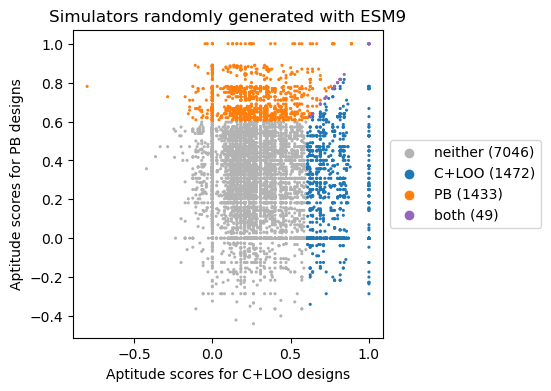

In [392]:
fig, ax = plt.subplots(figsize=(4, 4))

counts = dat.loc[:, ''].value_counts()

dat2 = pd.DataFrame({
    "cloo": dat.cloo,
    "pb": dat.pb,
    "v": dat.v,
    "": [f"{v} ({counts[v]})" for v in dat.loc[:, ""]]
})


sns.scatterplot(
    data=dat2.sort_values("v"), x="cloo", y="pb", ax=ax, hue="", palette=[".7", "C0", "C1", "C4"], s=5, linewidth=0,
)

ax.set(
    title="Simulators randomly generated with ESM9",
    xlabel="Aptitude scores for C+LOO designs", 
    ylabel="Aptitude scores for PB designs"
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

if conf.savefig:
    fig.savefig(f"{outputdir}/kappa_scatter_test9", **kwarg_savefig)

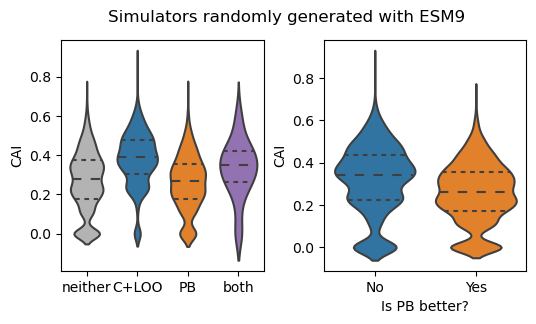

In [477]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
plt.subplots_adjust(wspace=.3)

# counts = dat.loc[:, ''].value_counts()

# dat2 = pd.DataFrame({
#     "cai": dat.cai,
#     "v": dat.v,
#     "": [f"{v}\n({counts[v]})" for v in dat.loc[:, ""]]
# })


sns.violinplot(data=dat, x="", y="cai", ax=ax[0], palette=[".7", "C0", "C1", "C4"], inner="quart")

sns.violinplot(
    data=dat.assign(
        avoid_cloo=list(map(lambda boolean: ["No", "Yes"][boolean], dat.cloo < dat.pb))
    ).sort_values("avoid_cloo", ascending=True), 
    x="avoid_cloo", y="cai",
    inner="quart"
)

ax[1].set_xlabel("Is PB better?")

[a.set(ylabel="CAI") for a in ax.ravel()]

plt.suptitle("Simulators randomly generated with ESM9")

if conf.savefig:
    fig.savefig(f"{outputdir}/cai_test9", **kwarg_savefig)

In [465]:
# model phi
cai_phi = cai(np.array([
    1, 1, 0, 0, 0, 1, 1, 0, -1,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 1, 0, 0,
    -1, 0, 0, 0, 0,
    0, -1, 0, 0,
    -1, 0, 0,
    0, 0,
    1
]))

In [464]:
# model psi
cai_psi = cai(np.array([
    1, -1, 0, 0, 0, 0, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, -1, 1, -1, 0, 0,
    1, -1, 1, 0, 0,
    1, -1, 0, 0,
    1, 0, 0,
    -1, 0,
    1
]))

In [466]:
# model lambda
cai_lambda = cai(np.array([
    1, -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0,
    1, -1, 1, 0, 0,
    0, -1, 0, 0,
    1, 0, 0,
    -1, 1,
    0
]))

<AxesSubplot: ylabel='CAI'>

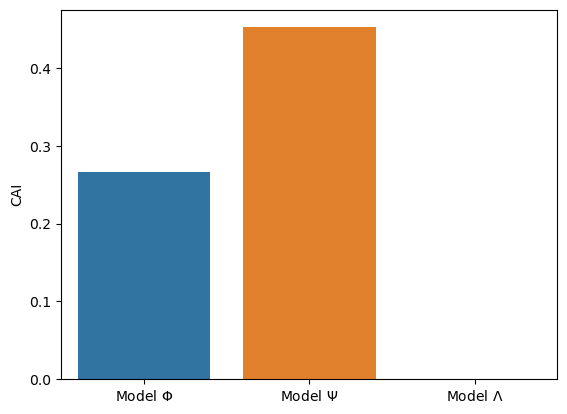

In [467]:
sns.barplot(
    data=pd.DataFrame({
        "": ["Model $\Phi$", "Model $\Psi$", "Model $\Lambda$"],
        "CAI": [cai_phi, cai_psi, cai_lambda]
    }),
    x="", y="CAI"
)

In [486]:
3 ** 45

2954312706550833698643

In [32]:
from typing import List
from doe_modules.preferences import textcolor

In [134]:
mapklike = [plt.cm.gist_rainbow_r((i + 2)/13) for i in range(11)]

edge_mapklike = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 1, 1, 0, 0, 0, 0, 0, 0,
    1, 1, 0, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 0, 0,
    0, 1, 0, 0, 0,
    0, 1, 0, 0,
    1, 0, 0,
    1, 0,
    1
]

name_mapklike = {
    1: "EGFR", 2: "ERBB2", 3: "MET",
    4: "GRB2", 5: "PLC",
    6: "SOS", 7: "PKC",
    8: "RAS", 9: "RAF", 10: "MEK", 11: "ERK"
}

In [143]:
class MAPKLike(AbstractSimulator):
    def __init__(
        self, 
        random_state: int = 0,
        kwarg_v: dict = dict(mean=1, sigma=.8),
        kwarg_a: dict = dict(mean=2, sigma=.3),
        kwarg_b: dict = dict(mean=1, sigma=.5)
    ):
        super().__init__(
            n_factor=11, random_state=random_state, cmap=mapklike, 
            name="MAPK-like"
        )
        edge_assignsment = edge_mapklike
        seeds = np.random.randint(0, 2**32, 3)
        np.random.seed(seeds[0])
        self.v = {
            i+1: vi for i, vi in enumerate(
                np.random.lognormal(**kwarg_v, size=self.n_factor)
            )
        }
        np.random.seed(seeds[1])
        self.a = {
            i: sign * a for i, a, sign in zip(
                np.arange(1, self.n_factor + 1).astype(int),
                np.random.lognormal(**kwarg_a, size=self.n_factor),
                edge_assignsment[:self.n_factor]
            )
        }
        np.random.seed(seeds[2])
        self.b = {
            i: sign * b for i, b, sign in zip(
                [
                    102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                    203, 204, 205, 206, 207, 208, 209, 210, 211,
                    304, 305, 306, 307, 308, 309, 310, 311,
                    405, 406, 407, 408, 409, 410, 411,
                    506, 507, 508, 509, 510, 511,
                    607, 608, 609, 610, 611,
                    708, 709, 710, 711,
                    809, 810, 811,
                    910, 911,
                    1011
                ],
                np.random.lognormal(**kwarg_b, size=55),
                edge_assignsment[self.n_factor:]
            )
        }

    def run(
        self, 
        design_array, 
        random_state: int = 0,
        kwarg_err: dict = dict(loc=0, scale=1),
    ):
        super().run(design_array=design_array, random_state=random_state)
        e = np.random.normal(**kwarg_err, size=self.n_factor + 1)
        f = lambda x: max(0, x)
        c = self.c
        
        upstreams = {}
        xs = {}
        idx_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        
        for i in idx_list:
            upstream_list = [ii for ii in idx_list if ii < i]
            upstream = 0 if len(upstream_list) == 0 else np.sum([self.b[100 * ii + i] * xs[ii] for ii in xs])
            xs = {**xs, i: f(c[i] * (self.v[i] + e[i] + upstream))}
            # print(xs)
        self.c = c
        self.x = xs
        self.y = f(sum([self.a[i + 1] * self.x[i + 1] for i in range(self.n_factor)]) + e[0])
        return self.y
    

    def plot(
        self,
        ax: plt.Axes,
        names: dict = None
    ):

        dat = pd.DataFrame(dict(
            x=[1, 4.5, 8, 3, 6, 3, 6, 3, 6, 9, 12], 
            y=[10, 10, 10, 7, 7, 4, 4, 1, 1, 1, 1]
        ))
        
        for i, (x, y) in enumerate(zip(dat.x, dat.y)):
            ax.fill_between([x - 1, x + 1], [y - .5] * 2, [y + .5] * 2, color=mapklike[i])


        box_top = -2
        box_bottom = -3

        ax.fill_between([1.5, 12.5], [box_bottom] * 2, [box_top] * 2, color=".7", alpha=.2)
        ax.text(7, (box_top + box_bottom) / 2, "output value"if names is None else "phenotype", ha="center", va="center")

        for i in range(self.n_factor):
            x, y = dat.x[i], dat.y[i]
            alpha = np.linspace(0.5, 1, self.n_factor)[i]
            ax.text(
                x, y, 
                "$x_{" + f"{(i + 1)}" + "}$" if names is None else names[i + 1], 
                va="center", ha="center", c=textcolor(mapklike[i]))
            
            if self.a[i + 1] != 0:
                ax.vlines(x, box_top, y, color=mapklike[i], zorder=-100, alpha=alpha)
                ax.scatter(
                    x, box_top + .25 if self.a[i + 1] > 0 else box_top, 
                    color=mapklike[i], marker="v" if self.a[i + 1] > 0 else "$-$"
                )
                # ax.text(x, box_top + 1, "$a_{" + f"{(i + 1)}" + "}$" if names is None else "", va="center", ha="left")
                
        ap = lambda c: dict(
            shrink=0, width=1, headwidth=5, 
            headlength=5, connectionstyle="arc3",
            facecolor=c, edgecolor=c
        )
        
        ax.annotate("", [3, 7.5], [1, 9.5], arrowprops=ap(mapklike[0]))
        ax.annotate("", [6, 7.5], [1, 9.5], arrowprops=ap(mapklike[0]))
        ax.annotate("", [3, 7.5], [4.5, 9.5], arrowprops=ap(mapklike[1]))
        ax.annotate("", [6, 7.5], [4.5, 9.5], arrowprops=ap(mapklike[1]))
        ax.annotate("", [3, 7.5], [8, 9.5], arrowprops=ap(mapklike[2]))
        ax.annotate("", [6, 7.5], [8, 9.5], arrowprops=ap(mapklike[2]))
        ax.annotate("", [3, 4.5], [3, 6.5], arrowprops=ap(mapklike[3]))
        ax.annotate("", [6, 4.5], [6, 6.5], arrowprops=ap(mapklike[4]))
        ax.annotate("", [3, 1.5], [3, 3.5], arrowprops=ap(mapklike[5]))
        ax.annotate("", [6, 1.5], [6, 3.5], arrowprops=ap(mapklike[6]))
        ax.annotate("", [5, 1], [4, 1], arrowprops=ap(mapklike[7]))
        ax.annotate("", [8, 1], [7, 1], arrowprops=ap(mapklike[8]))
        ax.annotate("", [11, 1], [10, 1], arrowprops=ap(mapklike[9]))

        ax.set_xlim(0, 14)
        ax.set_ylim(-3.0, 11)
        ax.axis("off");
        
#  
#         return None


    def simulate(
        self,
        design: DOE = None,
        n_rep: int = 1,
        random_state: int = 0,
        plot: bool = False,
        ax: np.ndarray = None,
        titles: List[str] = None,
        model_kwargs: dict = {},
        **kwargs
    ):
        super().simulate(
            design=design, n_rep=n_rep,
            random_state=random_state,
            plot=plot, ax=ax, 
            titles=titles,
            model_kwargs=model_kwargs,
            **kwargs
        )


    def scatterview(
        self,
        ax: plt.Axes
    ):
        super().scatterview(ax=ax)

Text(0.5, 1.0, 'MAPK signaling cascade\n(Kim M and Kim E, $BMC\\;Bioinformatics$ (2022))')

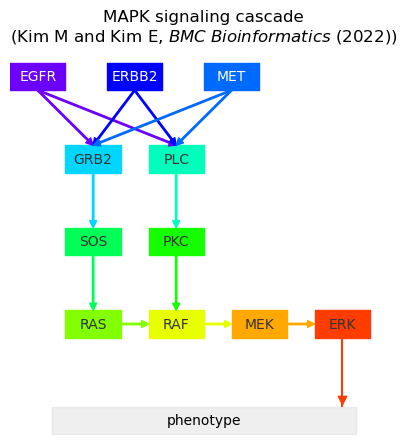

In [144]:
fig, ax = plt.subplots(figsize=(5, 5))

model = MAPKLike()

model.plot(ax=ax, names=name_mapklike)

ax.set_title("MAPK signaling cascade\n(Kim M and Kim E, $BMC\;Bioinformatics$ (2022))")

# if conf.savefig:
#     fig.savefig(f"{outputdir}/esm9", **kwarg_savefig)

Text(0.5, 1.0, 'MAPK-like')

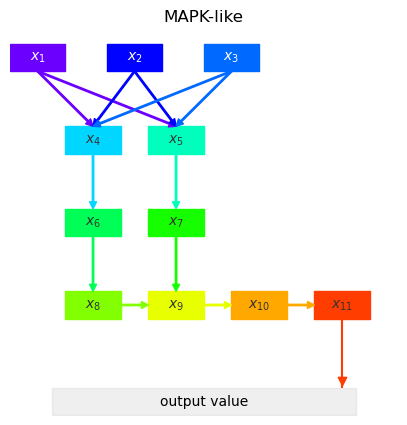

In [145]:
fig, ax = plt.subplots(figsize=(5, 5))

model = MAPKLike()

model.plot(ax=ax)

ax.set_title("MAPK-like")

# if conf.savefig:
#     fig.savefig(f"{outputdir}/esm9", **kwarg_savefig)

In [153]:
kwarg_err = dict(loc=0, scale=2)

mapk_ff, mapk_pb, mapk_cloo = [MAPKLike()] * 3
mapk_ff.simulate(design=FullFactorial, n_rep=3)
mapk_pb.simulate(design=PlackettBurman, n_rep=3)
mapk_cloo.simulate(design=CLOO, n_rep=3)

In [154]:
mapk_gt = MLR(mapk_ff).summary(anova=True, dtype=int, fill_nan=True)

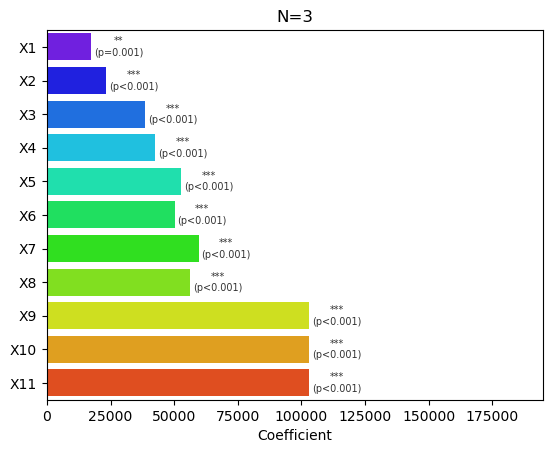

In [155]:
MLR(mapk_ff).plot()

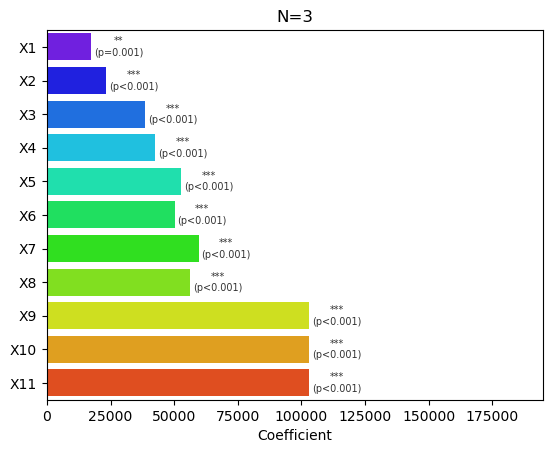

In [156]:
MLR(mapk_pb).plot()

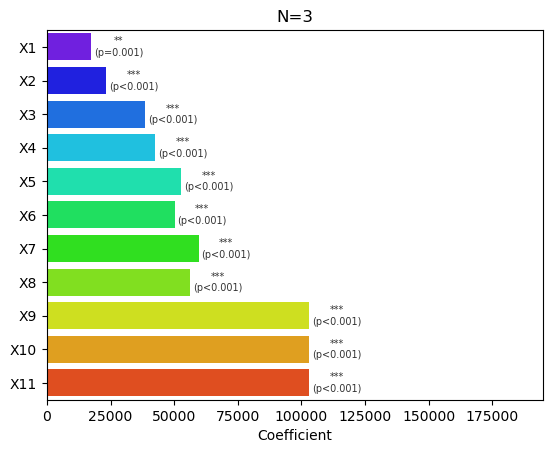

In [157]:
MLR(mapk_cloo).plot()